In [1]:
# Block 1: Imports, Config, and Helpers
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- File Paths ---
# These are the stereo pair images you provided
left_img_path = r"..\000057_10-image2.png"
right_img_path = r"..\000057_10-image3.png"

# --- Output Config ---
output_dir_q4 = Path("./outputs_q4")
output_dir_q4.mkdir(parents=True, exist_ok=True)

# --- KITTI Camera Parameters (for image_2 and image_3) ---
# These values are from the KITTI dataset calibration files.
# We need them to convert disparity (pixels) to depth (meters).
FOCAL_LENGTH_PIXELS = 721.5   # f_x from camera 2 (left)
BASELINE_METERS = 0.54        # Distance between cam 2 and cam 3

# --- Helper Function ---
def imshow(ax, img, title="", cmap=None):
    """Helper function to display images with matplotlib."""
    ax.imshow(img if cmap is None else img, cmap=cmap)
    ax.set_title(title); ax.axis("off")

Stereo pair loaded successfully: (375, 1242)


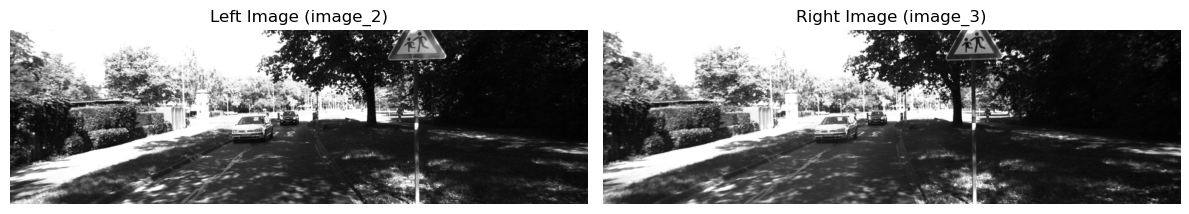

In [2]:
# Block 2: Load Stereo Image Pair
# Load as grayscale as specified in the assignment
imgL = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)

if imgL is None or imgR is None:
    print(f"Error: Could not load images. Check paths.")
else:
    print(f"Stereo pair loaded successfully: {imgL.shape}")
    
    # Display the stereo pair
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    imshow(axs[0], imgL, "Left Image (image_2)", cmap="gray")
    imshow(axs[1], imgR, "Right Image (image_3)", cmap="gray")
    plt.tight_layout()
    plt.show()

In [3]:
# Block 3: Configure and Compute Disparity with StereoSGBM
# StereoSGBM (Semi-Global Block Matching)
# These parameters are tuned for KITTI-like images.
print("Configuring StereoSGBM and computing disparity...")

# --- SGBM Parameters ---
minDisparity = 0
numDisparities = 128  # Must be > 0 and divisible by 16
blockSize = 5         # Must be an odd number >= 1
P1 = 8 * 1 * blockSize**2  # Penalty for 1-pixel disparity change
P2 = 32 * 1 * blockSize**2 # Penalty for >1-pixel disparity change
disp12MaxDiff = 1      # Max allowed difference in left-right disparity check
uniquenessRatio = 10   # Margin by which best match must win
speckleWindowSize = 100 # Max size of smooth disparity regions to filter
speckleRange = 32      # Max disparity variation allowed in a speckle

# Create the SGBM stereo matcher
stereo = cv2.StereoSGBM_create(
    minDisparity=minDisparity,
    numDisparities=numDisparities,
    blockSize=blockSize,
    P1=P1,
    P2=P2,
    disp12MaxDiff=disp12MaxDiff,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    mode=cv2.StereoSGBM_MODE_SGBM_3WAY # Use 3-way SGBM
)

# Compute the disparity map
# The result is a 16-bit signed integer (CV_16S)
# It has 4 bits of fractional precision (divide by 16)
disparity_SGBM = stereo.compute(imgL, imgR)

# Convert to float and scale by 16
disparity = disparity_SGBM.astype(np.float32) / 16.0

print("Disparity computation complete.")

Configuring StereoSGBM and computing disparity...
Disparity computation complete.


Normalizing and visualizing disparity map...
Saved disparity map to D:\git\Image and Video Processing\Lab_4\QUESTION4\outputs_q4


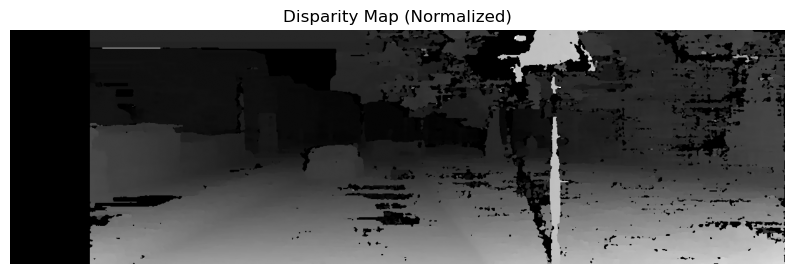

In [4]:
# Block 4: Normalize and Visualize Disparity Map
print("Normalizing and visualizing disparity map...")

# The 'disparity' map has negative values for invalid pixels
# We want to visualize the valid (positive) disparities
# A good visualization maps 0 disparity (far) to black
# and max disparity (close) to white.

# Make a copy for visualization
disparity_vis = disparity.copy()

# Set invalid disparities (<= 0) to 0 for a clean normalization
disparity_vis[disparity_vis <= 0] = 0

# Normalize the valid range (0 to numDisparities) to 0-255
# We use numDisparities as the max value for a consistent scale
disparity_vis = cv2.normalize(disparity_vis, None,
                              alpha=0, beta=255,
                              norm_type=cv2.NORM_MINMAX,
                              dtype=cv2.CV_8U)

# Display the normalized disparity map
fig, ax = plt.subplots(figsize=(10, 8))
imshow(ax, disparity_vis, "Disparity Map (Normalized)", cmap="gray")
fig.savefig(output_dir_q4 / "q4_disparity_map.png", bbox_inches='tight')
print(f"Saved disparity map to {output_dir_q4.resolve()}")
plt.show()

In [5]:
# Block 5: Convert Disparity to Depth Map
print("Converting disparity to depth map...")

# The formula is: depth = (focal_length * baseline) / disparity
# We must be careful about division by zero.

# Create a mask of valid disparity values (must be > 0)
valid_mask = disparity > 0

# Create an empty depth map
depth_map = np.zeros_like(disparity, dtype=np.float32)

# Calculate depth ONLY for valid disparity pixels
depth_map[valid_mask] = (FOCAL_LENGTH_PIXELS * BASELINE_METERS) / disparity[valid_mask]

print("Depth map calculation complete.")

Converting disparity to depth map...
Depth map calculation complete.


Normalizing and visualizing depth map...
Saved depth map to D:\git\Image and Video Processing\Lab_4\QUESTION4\outputs_q4


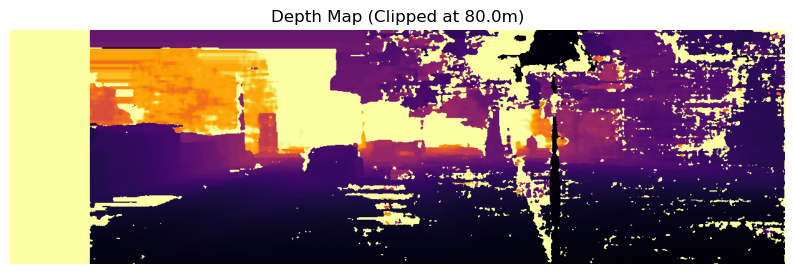

In [6]:
# Block 6: Normalize and Visualize Depth Map
print("Normalizing and visualizing depth map...")

# The 'depth_map' now has values in meters.
# Far-away objects have very large depth values, and close ones are small.
# Invalid pixels are 0.
# For visualization, it's common to clip to a max distance.
MAX_DEPTH_METERS = 80.0

# Make a copy for visualization
depth_vis = depth_map.copy()

# Set invalid (0) and very far pixels to the max depth for visualization
invalid_mask = (depth_vis == 0) | (depth_vis > MAX_DEPTH_METERS)
depth_vis[invalid_mask] = MAX_DEPTH_METERS

# Now, normalize the range [0, MAX_DEPTH_METERS] to 0-255
# We can apply a colormap to make it easier to read
depth_vis = cv2.normalize(depth_vis, None,
                          alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX,
                          dtype=cv2.CV_8U)

# Apply a colormap (INFERNO or PLASMA are good)
# Closer objects will be one color, farther objects another
depth_vis_color = cv2.applyColorMap(depth_vis, cv2.COLORMAP_INFERNO)
# Convert from BGR (OpenCV default) to RGB (Matplotlib default)
depth_vis_color = cv2.cvtColor(depth_vis_color, cv2.COLOR_BGR2RGB)

# Display the depth map
fig, ax = plt.subplots(figsize=(10, 8))
imshow(ax, depth_vis_color, f"Depth Map (Clipped at {MAX_DEPTH_METERS}m)")
fig.savefig(output_dir_q4 / "q4_depth_map.png", bbox_inches='tight')
print(f"Saved depth map to {output_dir_q4.resolve()}")
plt.show()

In [7]:
# Block 7: Analysis Comments
print("\n--- Block 7: Analysis ---")
print("Q: a) How disparity values relate to object distance?")
print("   A: Disparity is *inversely proportional* to distance (depth).")
print("      - High Disparity (large pixel shift): The object is very *close* to the cameras.")
print("      - Low Disparity (small pixel shift): The object is very *far* from the cameras.")
print("      - Zero Disparity: The object is at 'infinity' (e.g., the sky).")
print("      This is why `depth = (f * B) / disparity`.")
print("\nQ: b) Which regions appear closer or farther in the depth map?")
print("   A: - Closer Regions: In the grayscale disparity map, closer objects (like the road surface")
print("      at the bottom, street signs) are *brighter* (higher disparity). In the color depth map,")
print("      they will be at one end of the spectrum (e.g., yellow/white in INFERNO).")
print("   A: - Farther Regions: In the grayscale disparity map, farther objects (like distant")
print("      buildings and trees) are *darker* (lower disparity). In the color depth map,")
print("      they will be at the other end of the spectrum (e.g., dark purple/black in INFERNO).")


--- Block 7: Analysis ---
Q: a) How disparity values relate to object distance?
   A: Disparity is *inversely proportional* to distance (depth).
      - High Disparity (large pixel shift): The object is very *close* to the cameras.
      - Low Disparity (small pixel shift): The object is very *far* from the cameras.
      - Zero Disparity: The object is at 'infinity' (e.g., the sky).
      This is why `depth = (f * B) / disparity`.

Q: b) Which regions appear closer or farther in the depth map?
   A: - Closer Regions: In the grayscale disparity map, closer objects (like the road surface
      at the bottom, street signs) are *brighter* (higher disparity). In the color depth map,
      they will be at one end of the spectrum (e.g., yellow/white in INFERNO).
   A: - Farther Regions: In the grayscale disparity map, farther objects (like distant
      buildings and trees) are *darker* (lower disparity). In the color depth map,
      they will be at the other end of the spectrum (e.g., dar